![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 2</a>


## Customized Image Classification with AutoGluon

    
In this notebook, we load images and the corresponding labels into [AutoGluon](https://autogluon.mxnet.io/index.html) and use this data to obtain a neural network that can classify new images. 

This is different from traditional machine learning where we need to manually define the neural network and then specify the hyperparameters in the training process. Instead, with just a single call to AutoGluon’s fit function, AutoGluon automatically trains many models with different hyperparameter configurations and returns the model that achieved the highest level of accuracy.

**Note**: Please use **GPU** for training. CPU training will lead to an unceasing running script. 

1. <a href="#1">AutoGluon Data Format</a>      
2. <a href="#2">Downloading Data</a>
3. <a href="#3">Using AutoGluon to Fit Models</a>
4. <a href="#4">Understanding Model Results</a>


In [1]:
## make sure that `mxnet-cu101` (for GPU) shows here, rather than `mxnet` (for CPU)
!pip list | egrep mxnet-cu101

aws-mxnet-cu101mkl                 1.6.0     
mxnet-cu101mkl                     1.6.0     
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
## install autogluon
!pip install -q autogluon==0.0.9
!pip list | egrep autogluon

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
autogluon                          0.0.9     
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import autogluon as ag
from autogluon import ImageClassification as task

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/optimizer/optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


## 1. <a name="1">AutoGluon Data Format</a>
(<a href="#0">Go to top</a>)

To use AutoGluon for computer vision task training, we need to organize our data with the following structure:

    data/
    ├── train/
        ├── class1/
        ├── class2/
        ├── class3/
        ├── ...
    ├── test/
        ├── class1/
        ├── class2/
        ├── class3/
        ├── ...

Here each subfolder contains all images that belong to that category, e.g., `class1` contains all images belonging to the first class. We generally recommend at least 100 training images per class for reasonable classification performance, but this might depend on the type of images in your specific use-case.

## 2. <a name="2">Downloading Data</a>
(<a href="#0">Go to top</a>)

For demonstration purposes, we use a subset of the [Shopee-IET](https://www.kaggle.com/c/shopee-iet-machine-learning-competition/data) dataset from Kaggle. Each image in this data depicts a clothing item and the corresponding label specifies its clothing category. Our subset of the data contains the following possible labels: BabyPants, BabyShirt, womencasualshoes, womenchiffontop.

We download the data subset and unzip it using the following commands:

In [4]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
ag.unzip("shopee-iet.zip")

'data'

After the dataset is downloaded, we can check out the `data` folder, which manifests the folder structure as we desicribe above. Now let's load `train` and `test` into the `Dataset` object `train_dataset` and `test_dataset`, respectively.

In [5]:
train_dataset = task.Dataset('data/train')
test_dataset = task.Dataset('data/test', train=False)

## 3. <a name="3">Using AutoGluon to Fit Models</a>
(<a href="#0">Go to top</a>)

Now, let's fit a classifier using AutoGluon [task.fit()](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.ImageClassification.fit). The default search network is set as ResNet50 and ResNet18.

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2
Time out (secs) is 600


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.52.239/22895/1' processes=1 threads=4, memory=64.38 GB>, Resource: NodeResourceManager(4 CPUs, 1 GPUs))
})



Model file not found. Downloading.


100%|██████████| 55344/55344 [00:01<00:00, 39550.55KB/s]


Saving Training Curve in checkpoint/plot_training_curves.png


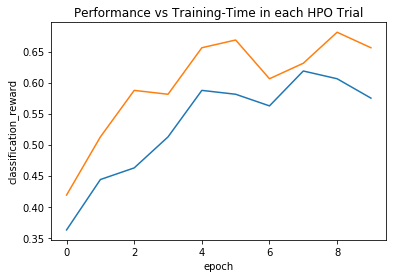

In [6]:
time_limits = 10 * 60 # how long fit() should run (in seconds)
classifier = task.fit(train_dataset, 
#                       net=['ResNet50_v1b', 'ResNet18_v1b'], # default
                      epochs=10,
                      time_limits=time_limits,
                      ngpus_per_trial=1, 
                      verbose=False)

## 4. <a name="4">Understanding Model Results</a>
(<a href="#0">Go to top</a>)

Autogluon also provides the training details, which can be accessed by calling `classifier.results`. For example, the default setting of `search_space` is to randomly search in candidate neural networks [ResNet50_v1b, ResNet18_v1b], with learning rate in $[0.001, 0.01]$ and weight decay in $[0.0001, 0.001]$.

In [7]:
classifier.results["search_space"]

OrderedDict([('net.choice', Categorical['ResNet50_v1b', 'ResNet18_v1b']),
             ('optimizer.learning_rate', Real: lower=0.001, upper=0.01),
             ('optimizer.wd', Real: lower=0.0001, upper=0.001)])

The best model's result and the total training time are also logged by `classifier.results` as below:

In [8]:
print('Top-1 validation accuracy: %.3f' % classifier.results['best_reward'])
print('Total Training Time : {}'.format(classifier.results['total_time']))


Top-1 validation accuracy: 0.656
Total Training Time : 551.3745880126953


To understand how does each candidate neural network perform, we can obtain further insights in `classifier.results["trial_info"]`:

In [9]:
classifier.results["trial_info"]

{'0': {'config': {'net.choice': 0,
   'optimizer.learning_rate': 0.0031622777,
   'optimizer.wd': 0.0003162278},
  'history': [{'epoch': 1,
    'classification_reward': 0.3625,
    'time_this_iter': 28.8189754486084,
    'time_since_start': 28.95328950881958},
   {'epoch': 2,
    'classification_reward': 0.44375,
    'time_this_iter': 17.289016246795654,
    'time_since_start': 46.24141311645508},
   {'epoch': 3,
    'classification_reward': 0.4625,
    'time_this_iter': 17.210651397705078,
    'time_since_start': 63.45209312438965},
   {'epoch': 4,
    'classification_reward': 0.5125,
    'time_this_iter': 17.68919348716736,
    'time_since_start': 81.14130783081055},
   {'epoch': 5,
    'classification_reward': 0.5875,
    'time_this_iter': 17.155976057052612,
    'time_since_start': 98.29706311225891},
   {'epoch': 6,
    'classification_reward': 0.58125,
    'time_this_iter': 17.281928539276123,
    'time_since_start': 115.5789086818695},
   {'epoch': 7,
    'classification_reward'

From above, we can conclude that the ResNet50_v1b will return us better results than ResNet18_v1b. 

You can also customize the search space and hyperparameter optimization (HPO) by modify the default parameters of `task.fit()`. More details are in this [tutorial](https://autogluon.mxnet.io/tutorials/image_classification/hpo.html)!